In [3]:
from scripts.unet3d import ResidualUNetSE3D
import torch
import torch.nn as nn
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim

## Data Preparation

1. Run `python data_download.py` to download the datasets into `training_data`, `test_data`, and `submission` directories, respectively.
2. Run `python data_format.py` to convert the data into HDF5 (`.h5`) format.
3. Run `python statistical.py` to calculate the mean and variance of the dataset. These statistics will be used to normalize both the noisy and clean data.

### Normalization Equation

Once you have the mean ($\mu$) and variance, the data can be normalized using the following equation:

$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

Where:
- $x$ is the raw data point,
- $\mu$ is the mean of the dataset,
- $\sigma$ is the standard deviation, calculated as $\sigma = \sqrt{\text{variance}}$.

This normalization is applied to both the noisy and clean data to ensure consistency in the input range.



In [ ]:
# uncomment the code for data download

# !python data_prep/data_download.py

In [ ]:
# uncomment the code for data transformation to .h5 formart 

#!python data_prep/data_format.py

## Training the Seismic Denoising Network

1.   The neural network we are training is a 3D U-Net residual network with the addition of Squeeze and Excitation (SE) blocks. This architecture is inspired by the paper [Deep Learning Semantic Segmentation for High-Resolution Medical Volumes](https://ieeexplore.ieee.org/abstract/document/9425041) and implemented based on [Accurate and Versatile 3D Segmentation of Plant Tissues at Cellular Resolution](https://doi.org/10.7554/eLife.57613).
2. The training loss includes an edge loss component based on the Laplacian operator, implemented according to the paper [Multi-Stage Progressive Image Restoration](https://doi.org/10.48550/arXiv.2102.02808).

3. In the first stage of training, we use both MSE (Mean Squared Error) and edge loss to accelerate the model’s learning. Once the initial learning phase is complete, we switch to SSIM (Structural Similarity Index Measure) for fine-tuning the model.



In [ ]:
# Modify the `config.yaml` file to adjust key parameters such as:
# - `batch_size`: Size of each mini-batch.
# - `num_epochs`: Number of training epochs.
# - `start`: Starting index for dataset file names.
# - `end`: Ending index for dataset file names.

# Example usage:
# We are using one HDF5 file for training over a single epoch to test the code.
# Set `num_epochs = 1`, `start = 1`, and `end = 1`.

# The `start` and `end` values map to specific dataset file names:
# - `start = 1` and `end = 2` will use the following files:
#   - `original_image-impeccable-train-data-part1.h5`
#   - `original_image-impeccable-train-data-part2.h5`

# To utilize the entire dataset, set `start = 1` and `end = 17`.
# This will include all HDF5 files for training:
# - `original_image-impeccable-train-data-part1.h5` to 
# - `original_image-impeccable-train-data-part17.h5`

# Once you have downloaded all the data in the HDF5 files, set the appropriate `start` and `end` values to train on the full dataset by running the Python script.

#uncomment for training
#!python scripts/train_model.py

Data loaded
Model loaded successfully
Using 1 GPUs
Epoch 1/1: 100% 562/562 [22:05<00:00,  2.36s/it]
Epoch 1 - Loss: 6.268122, LR: 5.000000e-05, Time: 1325.75s
Checkpoint saved: checkpoint_epoch_1.pth
Best model saved: best_model_epoch_1.pth


## Load the pretrained model


In [4]:
model = ResidualUNetSE3D(in_channels = 1, out_channels =1,f_maps=[16, 32, 64, 128, 256, 512,1024])
model = nn.DataParallel(model)
model_path = 'pretrained_model/checkpoint21_original_edge_cube_cubedepth_model_unet_normalize_best_train_epoch_1.pth'

state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)

model.load_state_dict(state_dict,strict = True)


<All keys matched successfully>

## Prediction Stage

In [5]:
predictions_path = (
    "test_data/image-impeccable-test-data"  # Path to your predictions folder or training data folder
)
seismic_filenames = sorted(
    [
        file.split("/")[0]
        for path, dirs, files in os.walk(predictions_path)
        for file in files
        if file.endswith(".npy")
    ]
)  # ensure that the filenames are sorted
print(seismic_filenames)
noise_data=[]
## you can add your own data path
pre_filenames = ['2024-06-10_0d6402b1', '2024-06-10_1a4e5680', '2024-06-10_1b9a0096', '2024-06-10_2bd82c05', '2024-06-10_3b118e17', '2024-06-10_43537d46', '2024-06-10_662066f4', '2024-06-10_971ac6dd', '2024-06-10_9871c8c6', '2024-06-10_b7c329be', '2024-06-10_bfd43f22', '2024-06-10_c952ed24', '2024-06-10_cec3da7f', '2024-06-10_eb45f27e', '2024-06-11_f46c20fe']
for dir in pre_filenames:
    seismic_dir_path = os.path.join(predictions_path, dir)
    print(f"Processing directory: {seismic_dir_path}")
    for path, subdirs, files in os.walk(seismic_dir_path):
        for file in files:
            if file.endswith(".npy"):
                seismic_file_path = os.path.join(path, file)
                seismic = np.load(seismic_file_path, allow_pickle=True)
                seismic = (seismic- 223.07626342773438)/23.740541458129883# Normalize based on the mean and variance
                noise_data.append(seismic)
                print(f"{file} loaded from {seismic_dir_path}")

['seismic_w_noise_vol_44318762.npy', 'seismic_w_noise_vol_44318762.npy', 'seismic_w_noise_vol_44319267.npy', 'seismic_w_noise_vol_44319267.npy', 'seismic_w_noise_vol_44319267.npy', 'seismic_w_noise_vol_44319267.npy', 'seismic_w_noise_vol_44319267.npy', 'seismic_w_noise_vol_44319268.npy', 'seismic_w_noise_vol_44319268.npy', 'seismic_w_noise_vol_44319271.npy', 'seismic_w_noise_vol_44319272.npy', 'seismic_w_noise_vol_44319337.npy', 'seismic_w_noise_vol_44319337.npy', 'seismic_w_noise_vol_44319345.npy', 'seismic_w_noise_vol_44399957.npy']
Processing directory: test_data/image-impeccable-test-data/2024-06-10_0d6402b1
seismic_w_noise_vol_44319345.npy loaded from test_data/image-impeccable-test-data/2024-06-10_0d6402b1
Processing directory: test_data/image-impeccable-test-data/2024-06-10_1a4e5680
seismic_w_noise_vol_44319272.npy loaded from test_data/image-impeccable-test-data/2024-06-10_1a4e5680
Processing directory: test_data/image-impeccable-test-data/2024-06-10_1b9a0096
seismic_w_noise_vo

cuda
(1259, 300, 300)
Prediction 1 took 157.0212 seconds


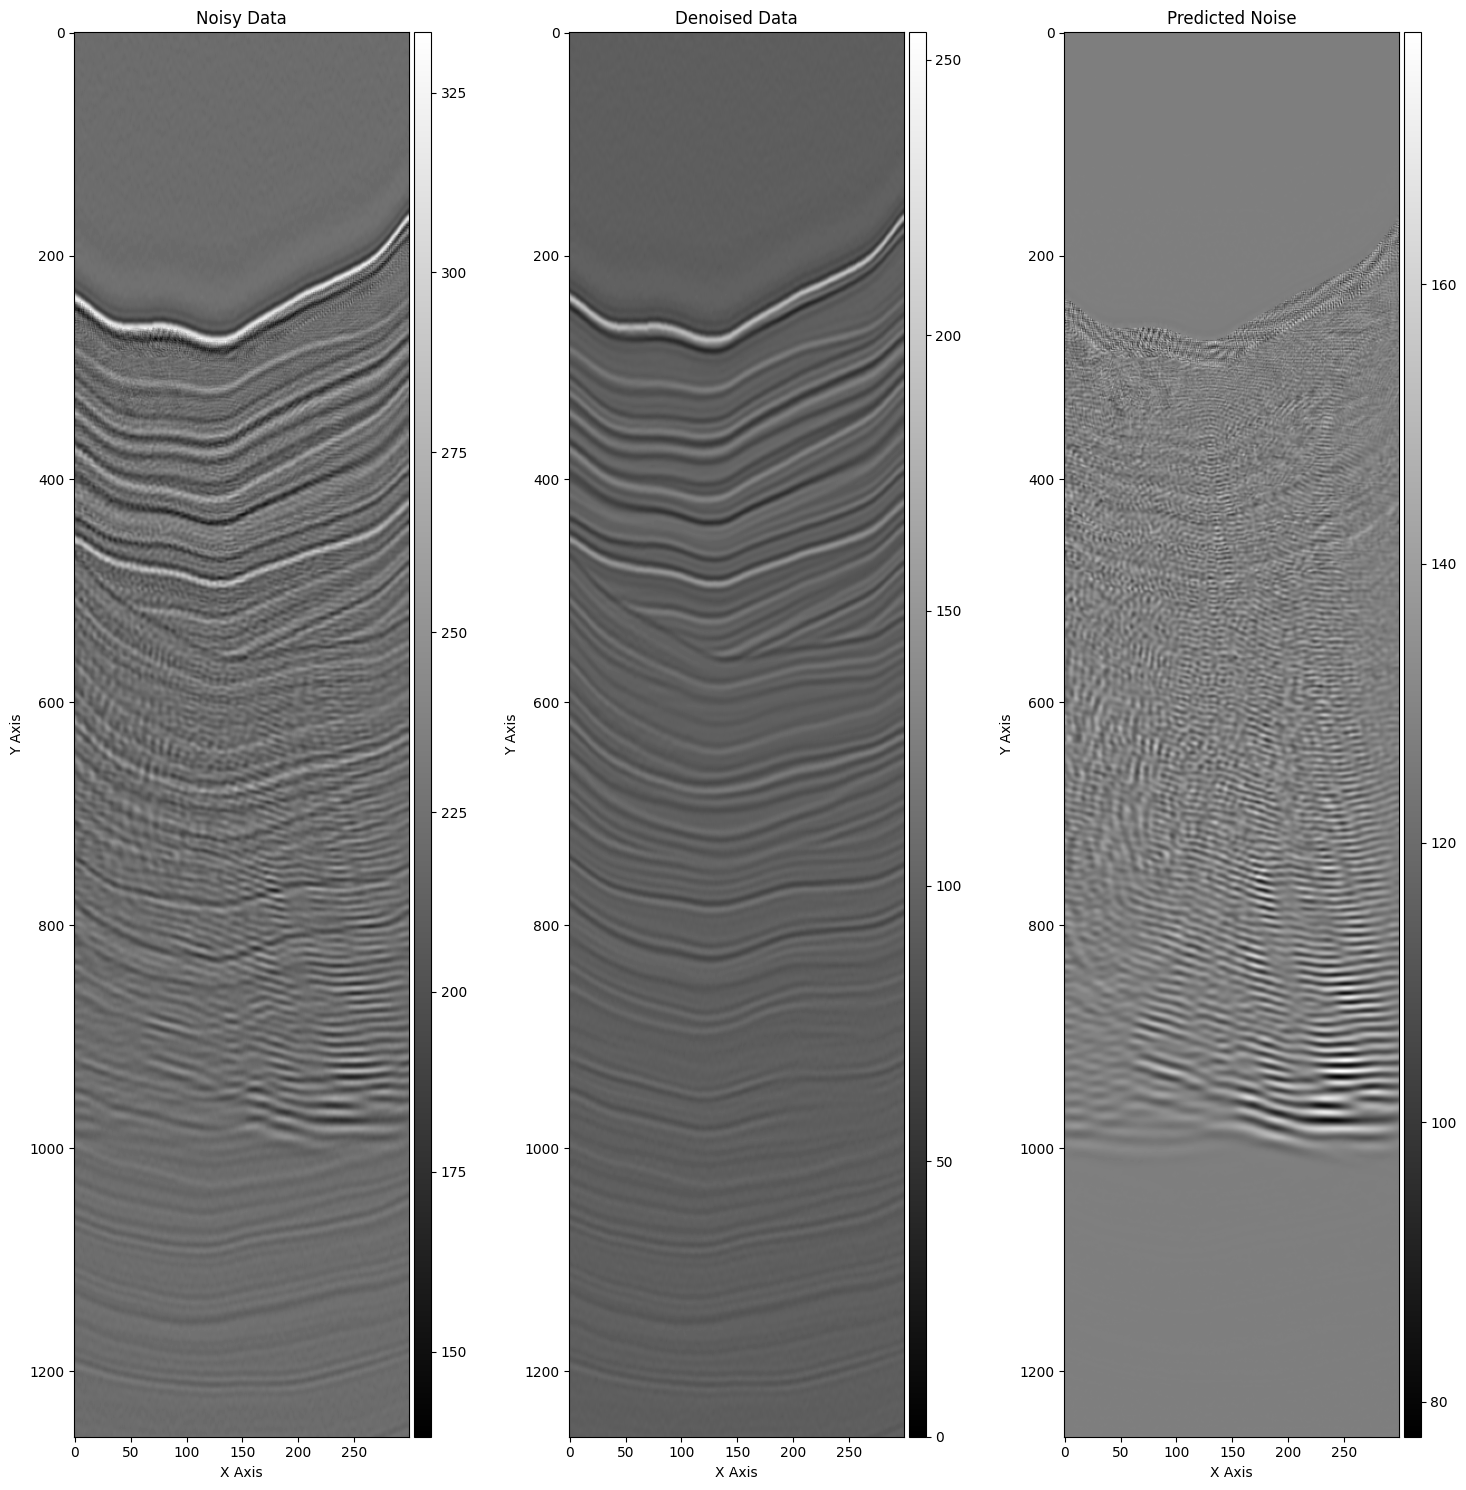

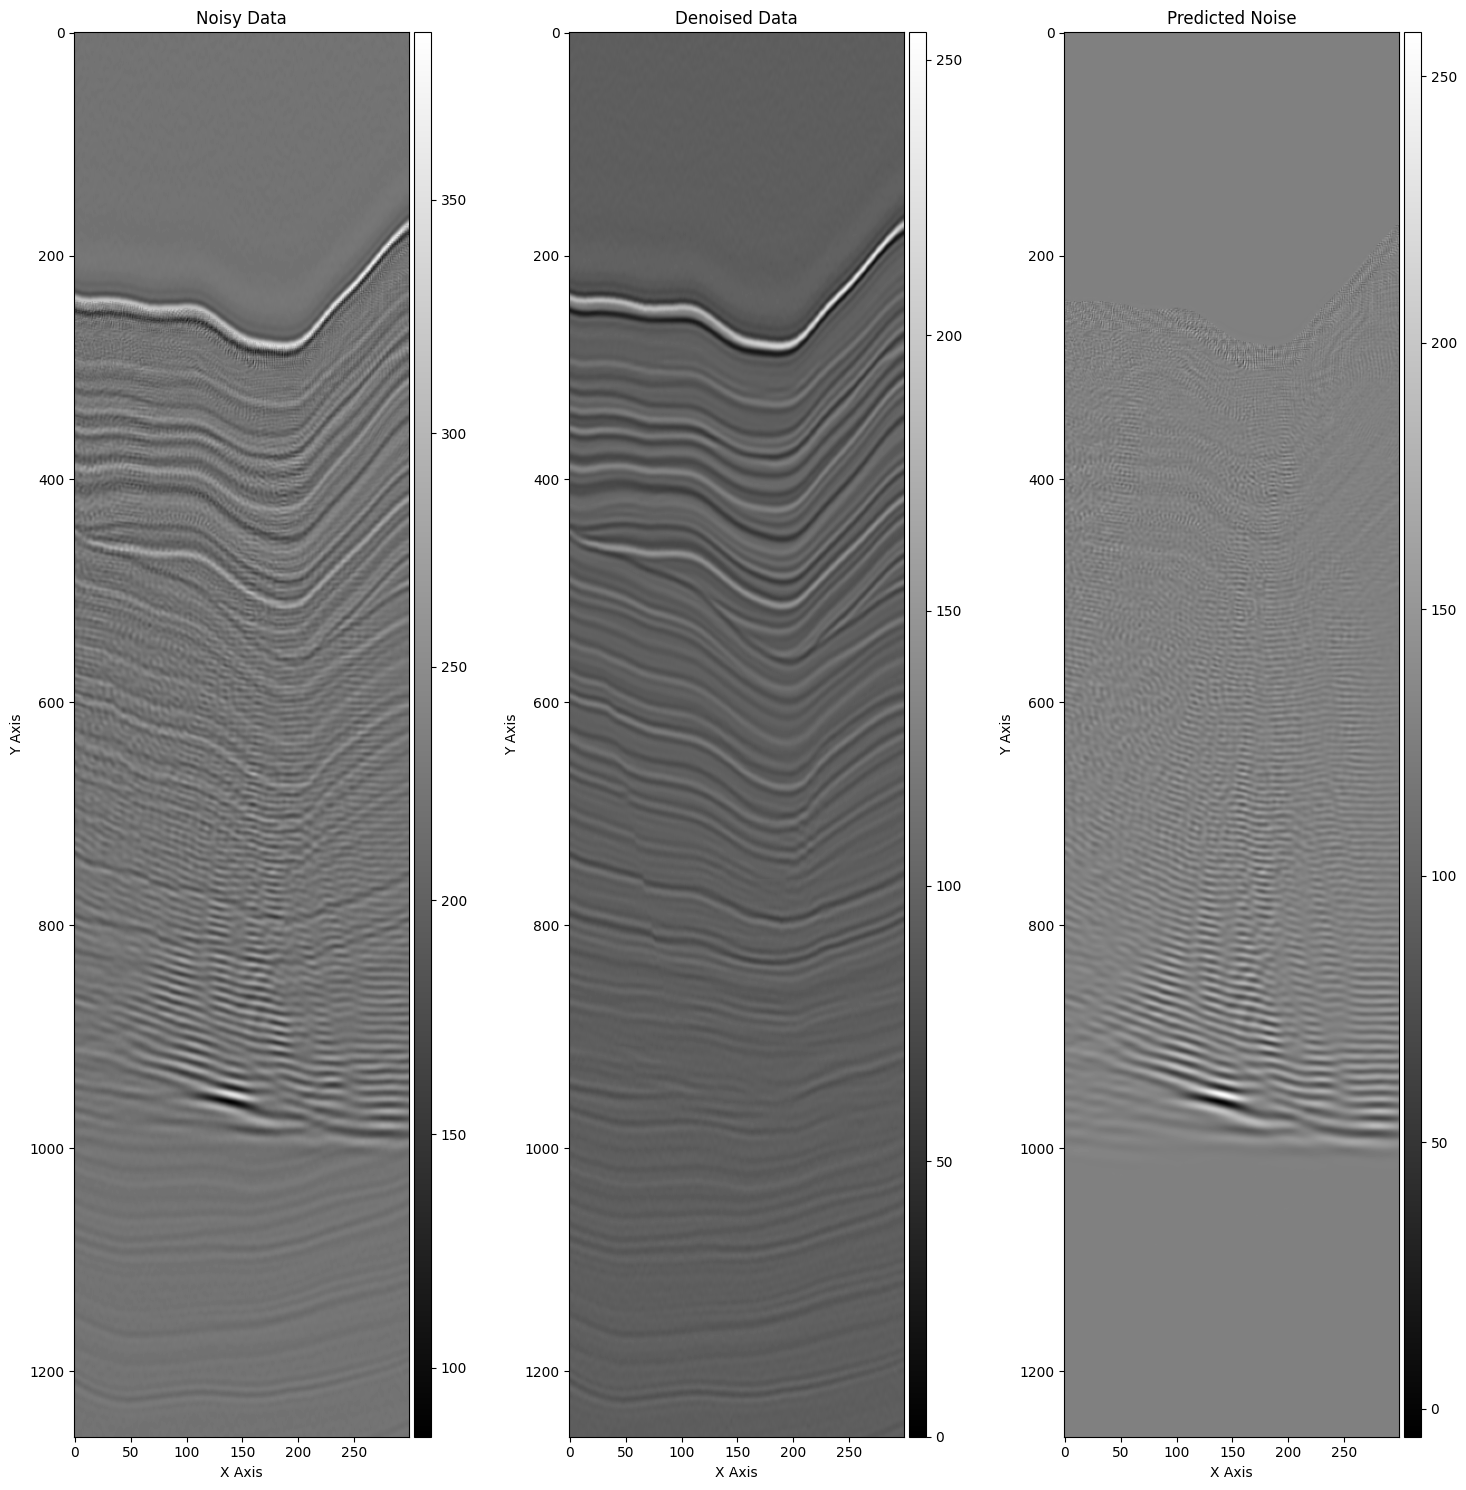

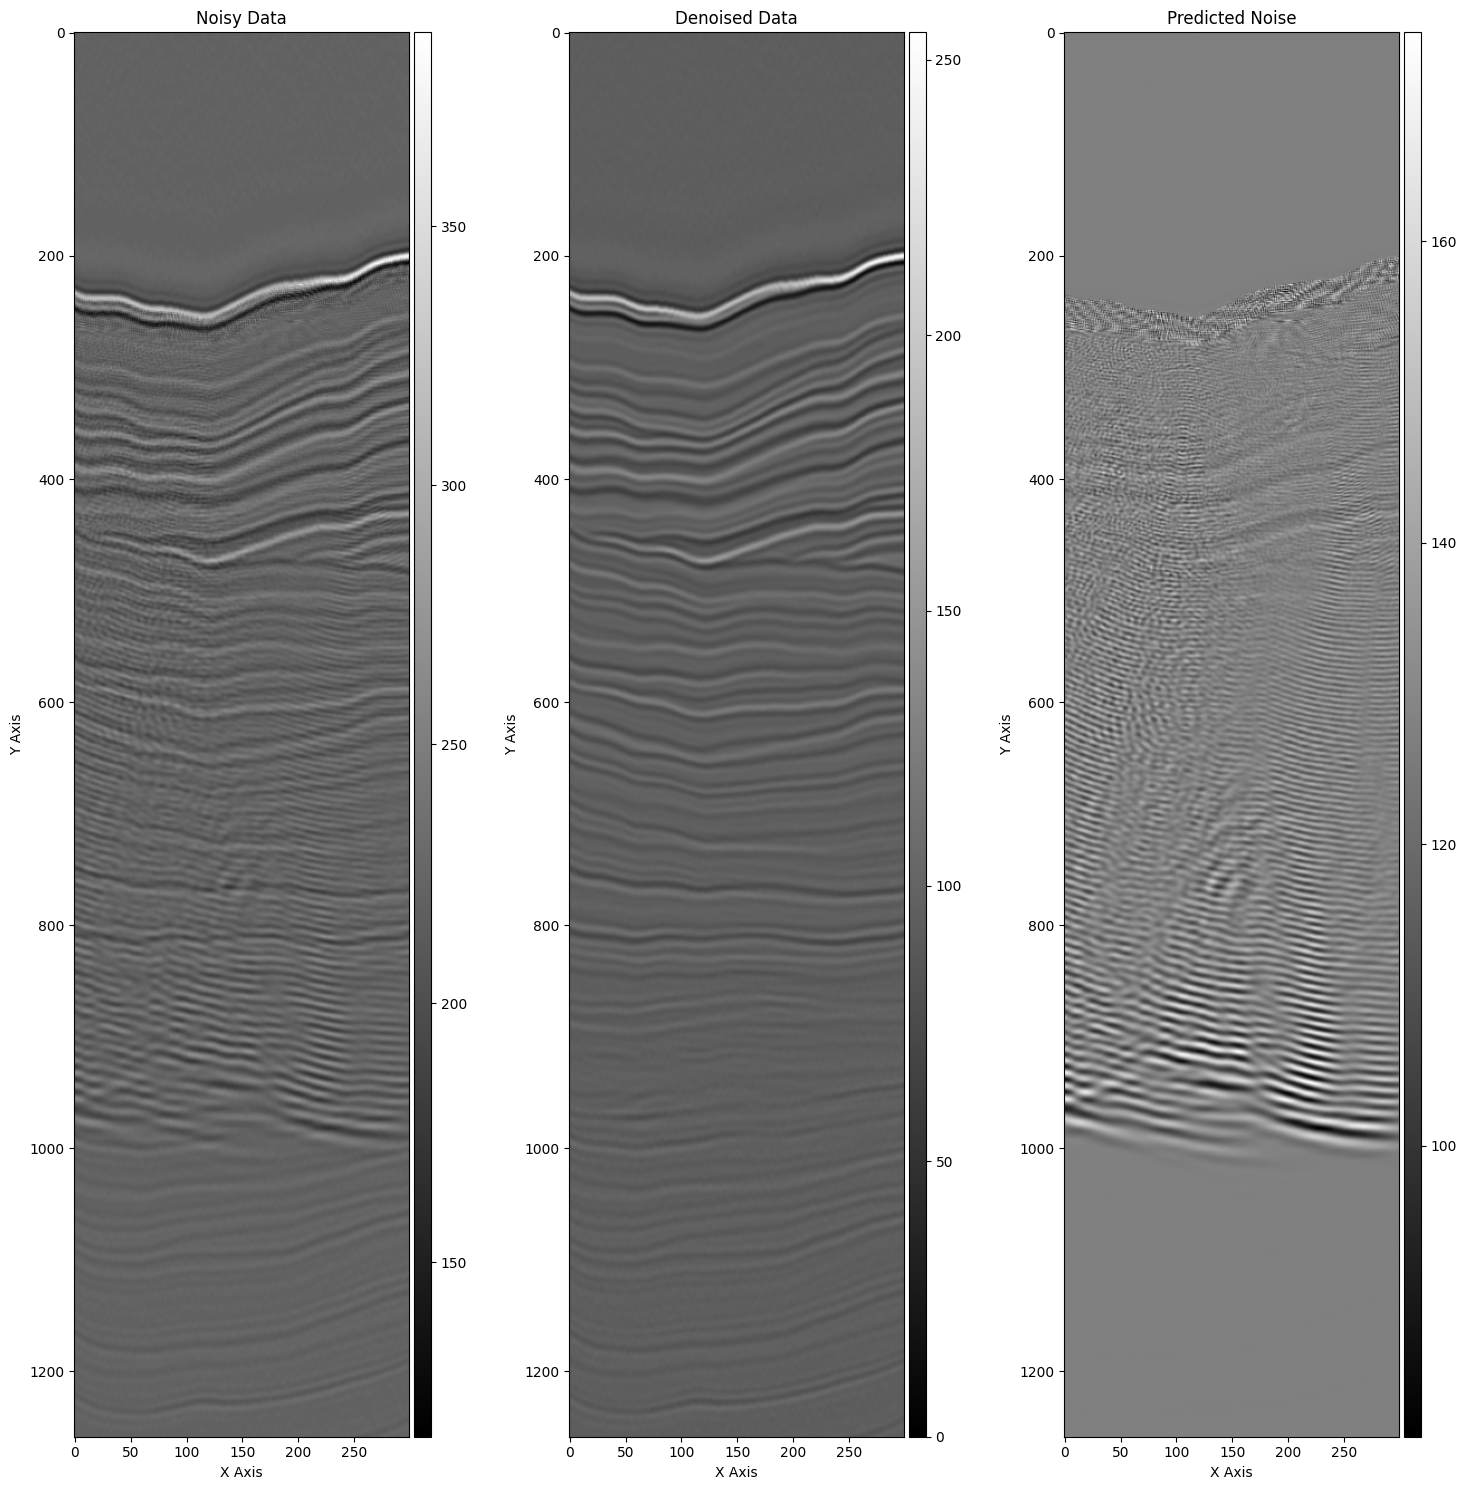

(1259, 300, 300)
Prediction 2 took 156.4619 seconds
(1259, 300, 300)
Prediction 3 took 156.3010 seconds
(1259, 300, 300)
Prediction 4 took 156.2081 seconds
(1259, 300, 300)
Prediction 5 took 156.4293 seconds
(1259, 300, 300)
Prediction 6 took 156.2654 seconds
(1259, 300, 300)
Prediction 7 took 156.3368 seconds
(1259, 300, 300)
Prediction 8 took 156.3839 seconds
(1259, 300, 300)
Prediction 9 took 156.3515 seconds
(1259, 300, 300)
Prediction 10 took 156.3285 seconds
(1259, 300, 300)
Prediction 11 took 156.2852 seconds
(1259, 300, 300)
Prediction 12 took 156.7179 seconds
(1259, 300, 300)
Prediction 13 took 156.3341 seconds
(1259, 300, 300)
Prediction 14 took 156.6688 seconds
(1259, 300, 300)
Prediction 15 took 156.3094 seconds
Sliced data saved successfully.


In [6]:
from prediction import prediction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# The input noisy data has a shape of (1259, 300, 300).
# The sliced inline data is represented as [:, :, idx] and saved with the key "_gt.npy-i".
# The sliced crossline data is represented as [:, idx, :] and saved with the key "_gt.npy-x".

# Set `save_3d_cube = True` to save the entire 3D prediction cube;
# otherwise, it will only save six slices of the prediction cube.
# Set `visualize = True` to visualize three denoising examples.
prediction(noise_data,pre_filenames,device, model, save_3d_cube = False,visualize = True,save_path = "submission_files/predictions.npz")

## Discussion

We observed that the concurrent wave-like noise is particularly difficult to remove and makes recovering the original seismic information challenging. One potential solution is to use the current model's predictions as a prior in training a generative model to better recover the corrupted seismic data.

Additionally, we found that the input data is sensitive to the scale, even with data augmentation techniques such as flipping and transposing. If the data scale falls outside the distribution of the training set, the model's performance deteriorates. This is likely because we are using fixed mean and variance values based on the entire training dataset (mean = 223.08, variance = 23.74). When we attempted to normalize the test dataset using its own cube-specific mean and variance, the performance did not improve compared to using the fixed values from the training dataset.

Given this, we suggest that applying Fourier Transform (FFT) feature extraction on both noisy and clear data, followed by inverse FFT (IFFT) for recovery, might offer a more robust solution than the current normalization technique.
